# Foundations Of AIML
## Session 11
### Experiment 1.1: Initialization of Weights

In this experiment we will see 'Xavier', 'Zero', 'normal' and 'he' intialization of weights in a Lenet neural network.

We will use CIFAR100 dataset. This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 50,000 training images and 10,000 testing images.

**LeNet-5** a pioneering 7-level convolutional network by LeCun et al in 1998, that classifies digits, was applied by several banks to recognise hand-written numbers on checks (cheques) digitized in 32x32 pixel images. The ability to process higher resolution images requires larger and more convolutional layers, so this technique is constrained by the availability of computing resources.

![alt text](https://cdn-images-1.medium.com/max/800/0*MU7G1aH1jw-6eFiD.png)

**Xavier Initialization** (from the name *Xavier Glorot*)

Assigning the network weights before we start training seems to be a random process, right? We don’t know anything about the data, so we are not sure how to assign the weights that would work in that particular case. One good way is to assign the weights from a Gaussian distribution. Obviously this distribution would have zero mean and some finite variance. Let’s consider a linear neuron:

y = w1x1 + w2x2 + ... + wNxN + b

With each passing layer, we want the variance to remain the same. **This helps us keep the signal from exploding to a high value or vanishing to zero** (Frequently asked interview question). In other words, we need to initialize the weights in such a way that the variance remains the same for x and y. This initialization process is known as Xavier initialization. You can read the original paper [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).



**Importing required packages**

In [0]:
cd 2018_04_07_Session11

/content/drive/TempCopies/2018_04_07_Session11


In [0]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58a56000 @  0x7f6be35c51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 4.5MB/s 
    100% |████████████████████████████████| 2.0MB 3.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0

#### Dataset Preparation

**transforms.Compose**  -  composes several transforms together.

**transforms.RandomCrop** - crops the given Python Imaging Library (PIL) Image at a random location.

**transforms.ToTensor** - converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

**transforms.Normalize** - normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. 

    input[channel] = (input[channel] - mean[channel]) / std[channel]

In [0]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) 


[Phase 1] : Data Preparation


In [0]:
# Preparing the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

#### Downloading and Loading the dataset

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.


In [0]:
# number of classes in the dataset
num_classes = 100

In [0]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='/data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='/data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


#### Let us define the network 

In [0]:
import torch.nn as nn
import torch.nn.functional as F

        
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

### Filter Visualisation at initialisation of parameters

We will visualize only the first layer in this experiment

Visualising zero


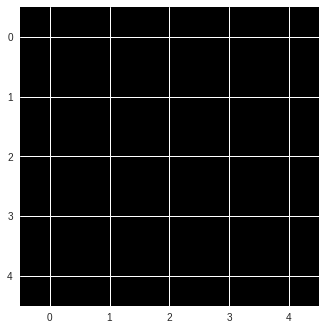

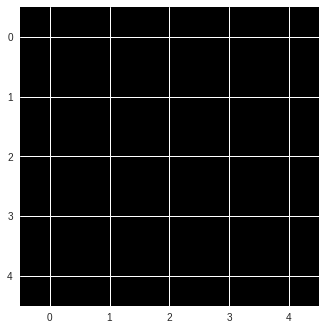

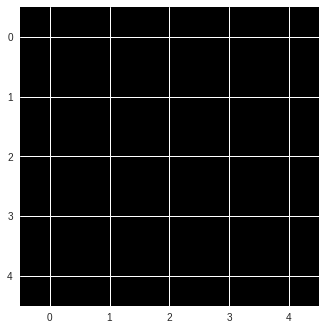

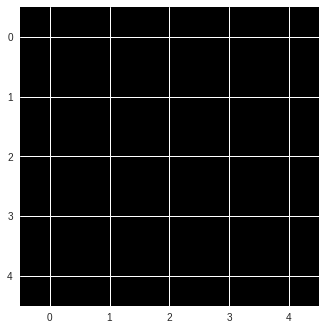

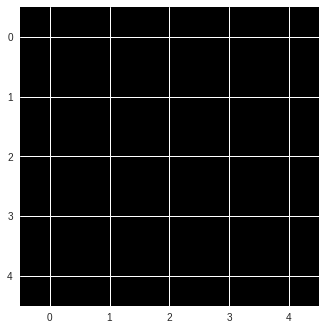

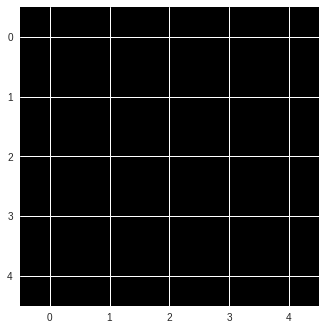

Visualising normal


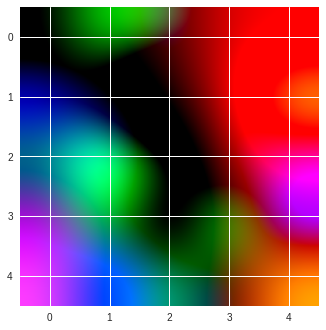

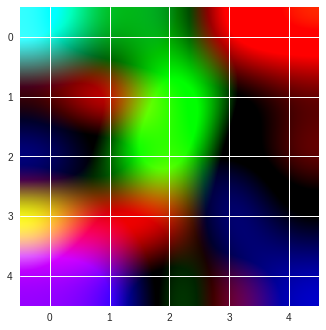

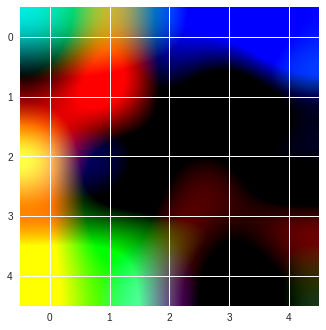

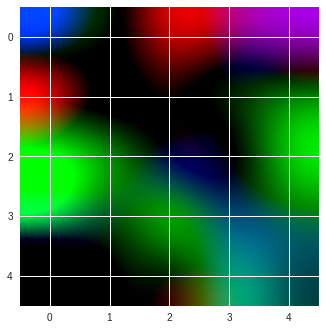

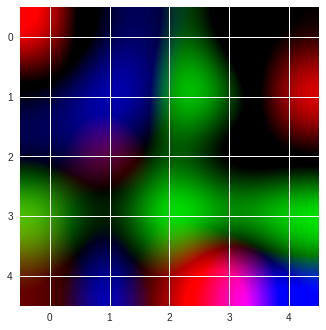

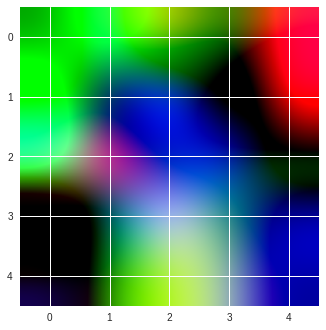

Visualising xavier


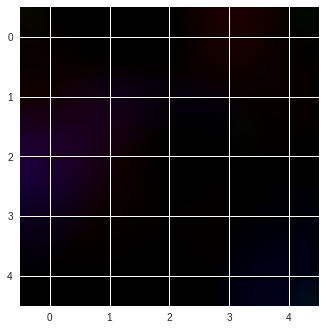

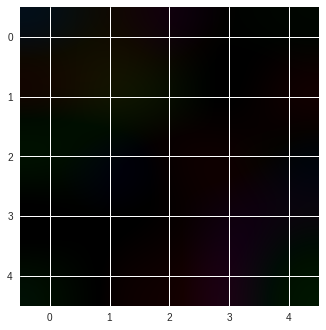

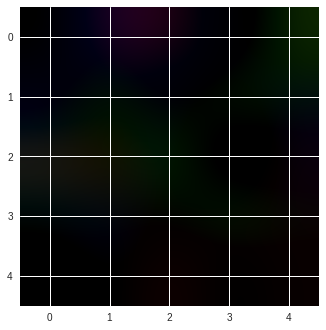

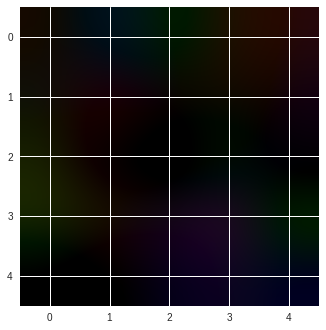

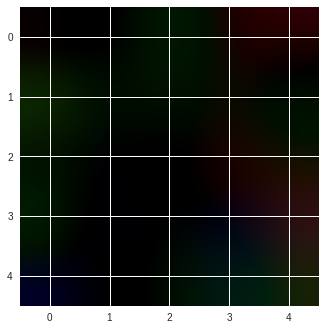

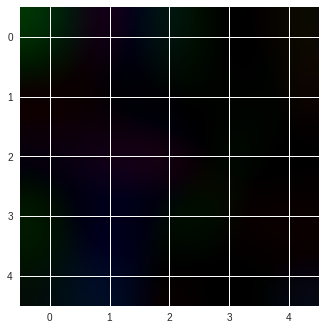

Visualising he


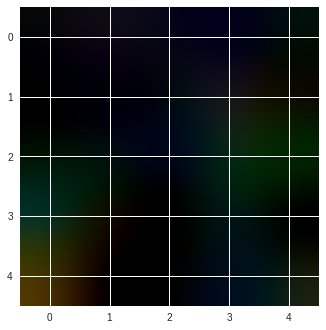

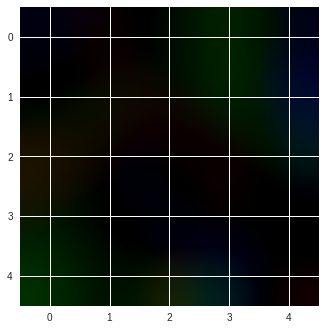

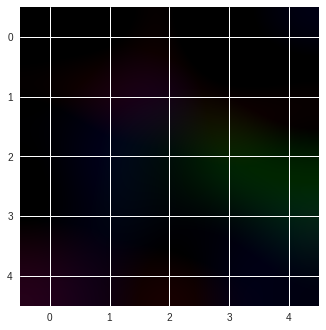

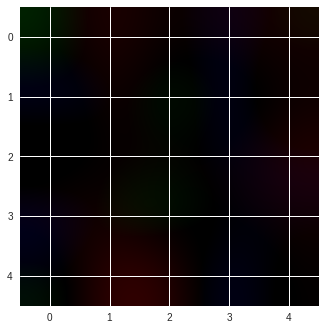

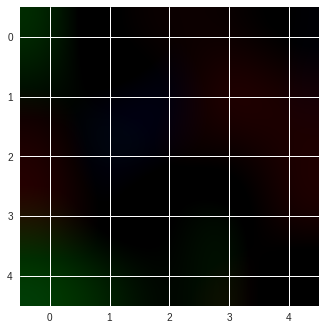

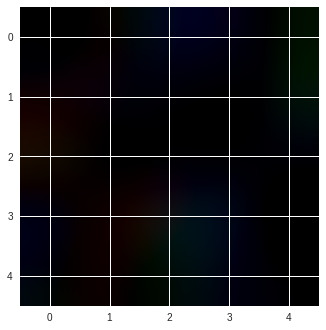

In [0]:
for init in ['zero', 'normal', 'xavier', 'he']:
    print('Visualising ' + init)
    net = LeNet(num_classes, init_mode=init)
    for p in net.parameters():
        for filter in range(p.size()[0]):
            plt.imshow(p[filter].data.numpy().transpose(1,2,0), interpolation='bicubic')
            plt.show()
        break
    

### Training with Xavier init

In [0]:
## Calling the model
net = LeNet(num_classes, init_mode='xavier')
if use_cuda:
    net.cuda()

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    ## Declaring the values
    train_loss = 0
    correct = 0
    total = 0
    ## Looping over the train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Checking for Gpu instance 
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        ## Optimizer
        optimizer.zero_grad()
        ## Converting inputs and targets into pytorch variables
        #inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        ## Storing the size of output
        size_ = outputs.size()
        ## reducting the dimenssion of outputs
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        ## backward pass
        loss.backward()
        ## optimizer
        optimizer.step()
        ## Calculating the training loss
        #train_loss += loss.data[0]
        train_loss += loss.item()
        ## predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        ## Storing the targets size
        total += targets.size(0)
        ## Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum()
        
        ## Printing the data 
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            ## printing progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Writing number of epoch, loss and accuracy into a file
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    net.eval()
    ## Declaring the variables
    test_loss = 0
    correct = 0
    total = 0
    #Looping over test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        # Converting inputs and targets into pytorch variable
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        ## Storing the size of output
        size_ = outputs.size()
        ## Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        ## Calculating the test loss
        #test_loss += loss.data[0]
        test_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        ## Storing the target size
        total += targets.size(0)
        # Calcuting the corrected values
        correct += predicted.eq(targets.data).cpu().sum()
        ## printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    ## printing the loss    
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Writing the number of epoch, loss and accuracy into a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking for directory
        if not os.path.isdir('../checkpoint'):
            # Creating a directory
            os.mkdir('../checkpoint')
        # saving the checkpoint
        torch.save(state, '../checkpoint_ckpt.t7')
        ## storing best accuracy value
        best_acc = acc

In [0]:
experiment = 'xavier_init'
# Creating a files in write mode
train_loss_file = open("./"+experiment+"train_loss.txt", "w")
val_loss_file = open("./"+experiment+"val_loss.txt", "w")

In [0]:
# Intiliazing the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
## Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    ## Traning the model
    train(epoch)
    ## Testing the model
    test(epoch)
    
# Closing the files   
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.609 | Acc: 1.000% (639/50000)   391/391 
 [==================================>] | Loss: 4.592 | Acc: 1.000% (137/10000)   100/100 
val_loss:  4.591681694984436 accuracy:  tensor(1)
Saving..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch: 1
 [==================================>] | Loss: 4.563 | Acc: 2.000% (1042/50000)  391/391 
 [==================================>] | Loss: 4.517 | Acc: 3.000% (310/10000)   100/100 
val_loss:  4.516675691604615 accuracy:  tensor(3)
Saving..

Epoch: 2
 [==================================>] | Loss: 4.431 | Acc: 3.000% (1789/50000)  391/391 
 [==================================>] | Loss: 4.331 | Acc: 4.000% (460/10000)   100/100 
val_loss:  4.330911417007446 accuracy:  tensor(4)
Saving..

Epoch: 3
 [==================================>] | Loss: 4.258 | Acc: 5.000% (2725/50000)  391/391 
 [==================================>] | Loss: 4.159 | Acc: 6.000% (675/10000

###### Let us plot the training curves

30 4


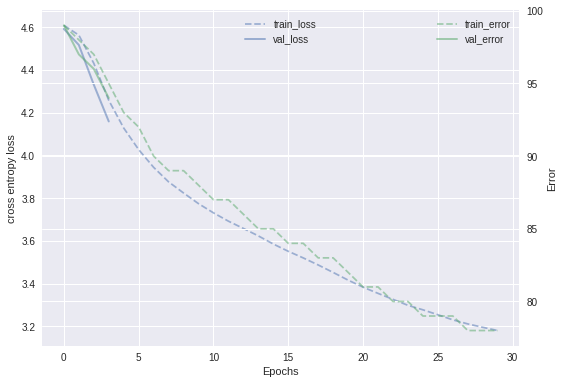

In [0]:
training_curves("./"+experiment) 

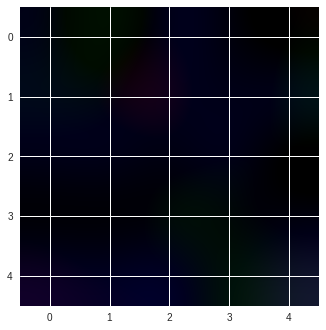

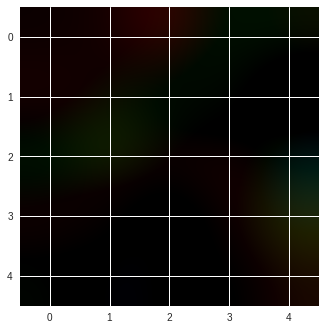

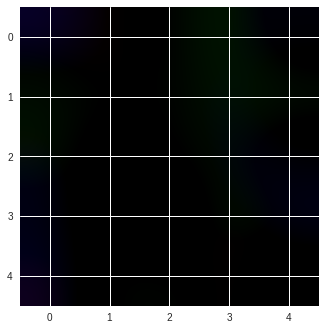

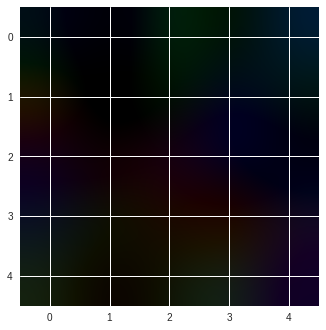

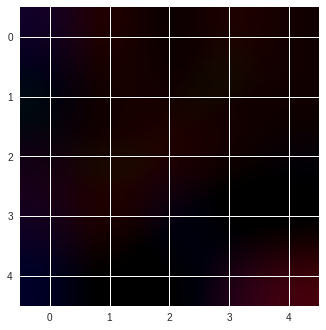

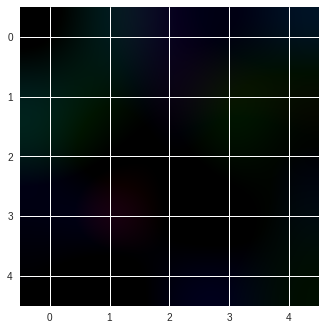

In [0]:
for p in net.parameters():
    for filter in range(p.size()[0]):
        plt.imshow(p[filter].data.cpu().numpy().transpose(1,2,0), interpolation='bicubic', cmap='gray')
        plt.show()
    break

#### Exercise 1. Compare training and test curves as well as the accuracy while using 'zero', 'normal', 'xavier', and 'he' inits and all other hyperparameters remaining same.

### Homework. 
a. It is hard to guess which filter is performing what task for this scenario. Try running this experiment on MNIST and visualize the filters.  
b. Also, replace LeNet with AlexNet/VGG and visualize the filters again.